In [1]:
import os
import mysql.connector as connection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import simplekml
import h3_util
from haversine import haversine, Unit
from sqlalchemy import create_engine
from sqlalchemy import text as sql_text

In [2]:
# Access environment variables
host = os.environ.get("MYSQL_HOST", "mysql")  # Default to "mysql" if not set
port = int(os.environ.get("MYSQL_PORT", 3306)) # Default to 3306
user = os.environ.get("MYSQL_USER", "root")
password = os.environ.get("MYSQL_PASSWORD") 
database = os.environ.get("MYSQL_DATABASE")

In [3]:
base_date_start = '2022-07-11'
base_date_end = '2022-07-15'

In [5]:
engine_uri = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}"
connection = create_engine(engine_uri)

query_fat_events = f"""
    SELECT fat_event.*
    FROM fat_event
    INNER JOIN dim_line ON dim_line.id = fat_event.dim_line_id
    INNER JOIN fat_most_relevant_itinerary AS fat_mri ON
    	fat_mri.line_code = dim_line.line_code AND 
        fat_mri.itinerary_id = fat_event.itinerary_id AND
        fat_mri.base_date = fat_event.base_date
    WHERE
    	fat_event.base_date BETWEEN '{base_date_start}' AND '{base_date_end}'
"""

query_dim_bus_stops = f"""
    SELECT 
    	*,
    	CASE 
    		WHEN type_norm LIKE 'Bus Terminal' THEN 
    			DENSE_RANK() OVER (ORDER BY name_norm) - 1
    		ELSE
    			legacy_id
    	END AS dummy_id
    FROM dim_bus_stop
"""

query_dim_lines = f"""
    SELECT *
    FROM dim_line
"""

query_fat_itineraries = f"""
    SELECT fat_itinerary.*
    FROM fat_itinerary
    INNER JOIN dim_line ON dim_line.id = fat_itinerary.dim_line_id
    INNER JOIN fat_most_relevant_itinerary AS fat_mri ON
    	fat_mri.line_code = dim_line.line_code AND 
    	fat_mri.itinerary_id = fat_itinerary.itinerary_id AND
    	fat_mri.base_date = fat_itinerary.base_date
    WHERE
    	fat_itinerary.base_date BETWEEN '{base_date_start}' AND '{base_date_end}'
"""

fat_events = pd.read_sql_query(sql_text(query_fat_events), connection.connect())
dim_bus_stops = pd.read_sql_query(sql_text(query_dim_bus_stops), connection.connect())
dim_lines = pd.read_sql_query(sql_text(query_dim_lines), connection.connect())
fat_itineraries = pd.read_sql_query(sql_text(query_fat_itineraries), connection.connect())

In [6]:
logs = pd.merge(
    fat_events[['dim_line_id', 'vehicle', 'itinerary_id', 'event_timestamp', 'seq', 'dim_bus_stop_id', 'base_date']], 
    dim_bus_stops[['id', 'dummy_id']], 
    left_on = 'dim_bus_stop_id', 
    right_on = 'id', 
    how = 'inner'
).drop(
    "id",
    axis = 1
).merge(
    dim_lines[["id", "line_code"]],
    left_on = 'dim_line_id', 
    right_on = 'id', 
    how = 'inner'
).drop(
    "id",
    axis = 1
)

itineraries = fat_itineraries.merge(
    dim_bus_stops[['id', 'dummy_id']],
    left_on = 'bus_stop_id',
    right_on = 'id',
    how = 'inner'
).drop(
    ["id_x", "id_y", "next_bus_stop_delta_s", "last_update"],
    axis = 1
).merge(
    dim_bus_stops[['id', 'dummy_id']],
    left_on = 'next_bus_stop_id',
    right_on = 'id',
    how = 'inner'
).drop(
    "id",
    axis = 1
).rename(
    columns = {
        "dummy_id_x":"dummy_id",
        "dummy_id_y":"next_dummy_id"
    }
).merge(
    dim_lines[["id", "line_code"]],
    left_on = 'dim_line_id', 
    right_on = 'id', 
    how = 'inner'
).drop(
    "id",
    axis = 1
).drop_duplicates()

In [7]:
grouped = logs.sort_values(by = 'event_timestamp').groupby(['dummy_id', 'base_date'])

In [8]:
df_bus_availability = grouped.rolling(
    window = "10min", min_periods = 1, on = "event_timestamp", closed = "both"
).agg(
     {'vehicle': 'count'}
).reset_index()

In [10]:
dim_bs = dim_bus_stops.groupby(by = ['dummy_id', 'name_norm', 'type_norm']).agg(
    {
        'latitude': 'mean',
        'longitude': 'mean'
    }
).reset_index()

# Mapping dictionary for replacing values
mapping = {
    "Bus terminal": "Terminal",
    "Street bus stop": "Ponto de rua",
    "Tube station": "Estação tubo",
    "Dawn bus": "Madrugueiro",
    "Tourism line": "Linha turística",
    "Others": "Outros"
}

# Replacing values in the 'type_norm' column
dim_bs['type_norm'] = dim_bs['type_norm'].map(mapping)

# Loading neighborhood information
bairro_map = h3_util.load_bairro_data('bairros.csv')
dim_bs['neighborhood'] = dim_bs.apply(
    lambda x: h3_util.get_bairro_from_h3(
        h3_util.lat_lng_to_h3(x.latitude, x.longitude, 10), 
        bairro_map,
        x.name_norm
    ), axis = 1
)

df_bus_availability['hour'] = df_bus_availability.event_timestamp.dt.hour
df_bus_availability.query('hour not in [0,1,2,3,4]', inplace = True)
df_bus_availability = pd.merge(df_bus_availability, dim_bs)

# Average number of vehicles aggregated per hour
df_bus_availability = df_bus_availability.groupby(by = ['dummy_id','name_norm','type_norm','hour']).agg(
    {
        'vehicle': 'mean'
    }
).reset_index()

df_bus_availability.query("type_norm in ['Terminal', 'Ponto de rua', 'Estação tubo']", inplace = True)

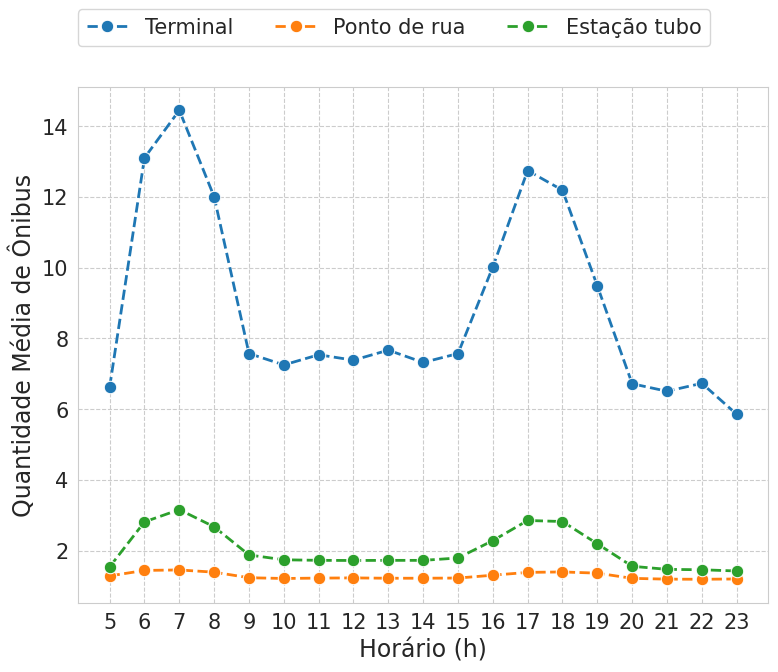

In [12]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.hour, y = df_bus_availability.vehicle, estimator='mean', err_style = None, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = df_bus_availability.type_norm, hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], palette = sns.color_palette("tab10", 3), ax = axes)
g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Horário (h)", fontsize = 17)
g.set_ylabel("Quantidade Média de Ônibus", fontsize = 17)
plt.savefig('bus_availability.png', format='png', dpi=300);

In [13]:
df_bus_availability_day = df_bus_availability.groupby(by = ['dummy_id','name_norm','type_norm']).agg(
    {
        'vehicle': 'mean'
    }
).reset_index()

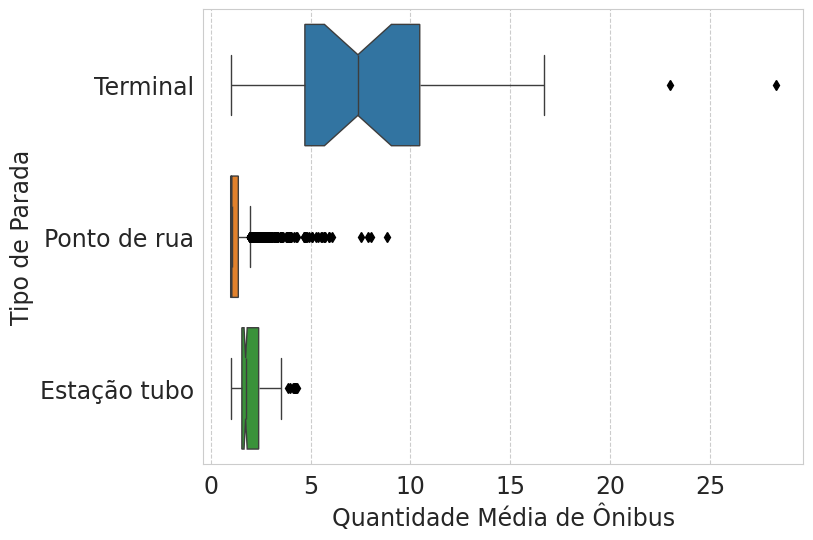

In [14]:
fig, axes = plt.subplots(figsize = (10, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(x = df_bus_availability_day.vehicle, y = df_bus_availability_day.type_norm, linewidth = 1.0, hue = df_bus_availability_day.type_norm, palette = sns.color_palette("tab10", 3), notch = True, order = ['Terminal', 'Ponto de rua', 'Estação tubo'], hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 17)
g.set_xlabel("Quantidade Média de Ônibus", fontsize = 17)
g.set_ylabel("Tipo de Parada", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('daily_avg_bus_availability.png', format='png', dpi=300)

In [15]:
# Select only bus stops and tube stations located on the street
df_bus_availability_day.query(r"type_norm != 'Terminal'", inplace = True)

In [16]:
stat = df_bus_availability_day.vehicle.describe().to_frame().transpose()

In [17]:
stat

,count,mean,std,min,25%,50%,75%,max
vehicle,6308.0,1.306756,0.535606,1.0,1.0,1.069486,1.429144,8.825969


In [18]:
# Identify and select outliers: defined as values greater than Q3 + 1.5 * IQR
out = stat["75%"] + 1.5 * (stat["75%"] - stat["25%"])
top = df_bus_availability_day.query(f"vehicle >= {out.vehicle}")

In [19]:
top.sort_values('vehicle', ascending = False)

,dummy_id,name_norm,type_norm,vehicle
3009,150331.0,"Av. Winston Churchill, 2472 - Capão Raso",Ponto de rua,8.825969
3338,150751.0,"Av. Winston Churchill, 2677 - Capão Raso",Ponto de rua,8.021563
3008,150330.0,"Av. Winston Churchill, 2546 - Capão Raso",Ponto de rua,7.868614
3010,150332.0,"Rua Léon Nicolas, 2081 - Capão Raso",Ponto de rua,7.505199
4061,170121.0,"Rodovia BR476 - Pista Lateral, 20916 - Pinheir...",Ponto de rua,6.085926
...,...,...,...,...
4901,180228.0,"Rua Eduardo Sprada, 3958 - Campo Comprido",Ponto de rua,2.078479
4853,180179.0,"Rua João Dembinski, 1340 - Cidade Industrial",Ponto de rua,2.078415
615,120019.0,"Av. Anita Garibaldi, 3436 - São Lourenço",Ponto de rua,2.077964
2936,150250.0,"Rua Alferes Poli, 1640 - Rebouças",Ponto de rua,2.075789


In [20]:
top = pd.merge(top, dim_bus_stops[['legacy_id', 'dummy_id']])

In [21]:
cluster_centroids = top.sort_values(by = "vehicle", ascending = False).dummy_id.to_list()

In [22]:
merge_df = dim_bs.query(
    f"dummy_id == {cluster_centroids[0]}"
).merge(
    dim_bs,
    how = "cross"
)
merge_df['d'] = merge_df.apply(
    lambda row: haversine(
        (row["latitude_x"], row["longitude_x"]), (row["latitude_y"], row["longitude_y"]),
        unit = Unit.METERS),
    axis = 1
)
merge_df['centre'] = np.where(merge_df['dummy_id_x'] == merge_df['dummy_id_y'], 1, 0)
merge_df.query(
    "d <= 600"
)[['dummy_id_y', 'centre']].rename(
    columns = {'dummy_id_y': 'dummy_id'}
)

,dummy_id,centre
250,108123.0,0
251,108124.0,0
3132,150270.0,0
3133,150271.0,0
3134,150272.0,0
3191,150330.0,0
3192,150331.0,1
3193,150332.0,0
3194,150334.0,0
3547,150751.0,0


In [23]:
# Build the clusters from the outliers
cluster_centroids = top.sort_values(by = "vehicle", ascending = False).dummy_id.to_list()
clusters = []
dummy_ids = []
c = 0
while len(cluster_centroids) > 0:
    merge_df = dim_bs.query(
        f"dummy_id == {cluster_centroids[0]}"
    ).merge(
        dim_bs,
        how = "cross"
    )
    merge_df['d'] = merge_df.apply(
        lambda row: haversine(
            (row["latitude_x"], row["longitude_x"]), (row["latitude_y"], row["longitude_y"]),
            unit = Unit.METERS),
        axis = 1
    )
    merge_df['centre'] = np.where(merge_df['dummy_id_x'] == merge_df['dummy_id_y'], 1, 0)
    cluster = merge_df.query(
        "d <= 600"
    )[['dummy_id_y', 'centre']].rename(
        columns = {'dummy_id_y': 'dummy_id'}
    )
    cluster["cluster"] = c
    clusters.append(cluster)
    for item in cluster.dummy_id.to_list():        
        if item in cluster_centroids:
            cluster_centroids.remove(item)    
    cluster.query("dummy_id not in @dummy_ids", inplace = True)
    dummy_ids.extend(cluster.dummy_id.to_list())
    dummy_ids = list(dict.fromkeys(dummy_ids))    
    c = c + 1
    print(len(cluster_centroids))
clusters = pd.concat(clusters, ignore_index = True)

444
435
433
425
412
411
409
404
395
379
376
370
361
352
351
343
331
320
314
309
299
291
290
282
278
273
266
260
254
249
245
242
237
233
230
229
228
225
221
217
216
214
207
201
196
193
191
187
183
182
176
166
165
162
156
148
142
138
136
127
123
119
115
114
113
112
111
109
105
102
100
95
92
89
87
85
83
79
77
72
70
69
67
65
63
62
60
54
51
47
42
41
38
34
31
25
23
22
18
14
12
10
9
7
6
5
2
1
0


In [30]:
clusters = clusters.merge(
    clusters.query('centre == 1').merge(
        dim_bs[['dummy_id', 'neighborhood']]
    )[['cluster', 'neighborhood']]
)

In [31]:
# Build bus stop pairs from the clusters
all_pairs = []
for cluster in clusters.cluster.unique():
    pairs = clusters.query(f"cluster == {cluster}")[["dummy_id"]].merge(
        clusters.query(f"cluster == {cluster}")[["dummy_id"]], how = "cross"
    )
    pairs = pairs.merge(
        dim_bs[["dummy_id", "latitude", "longitude"]],
        left_on = "dummy_id_x",
        right_on = "dummy_id"
    ).drop(
        "dummy_id",
        axis = 1
    ).merge(
        dim_bs[["dummy_id", "latitude", "longitude"]],
        left_on = "dummy_id_y",
        right_on = "dummy_id"
    ).drop(
        "dummy_id",
        axis = 1
    )    
    pairs["dist"] = pairs.apply(
        lambda row: haversine(
            (row["latitude_x"], row["longitude_x"]), (row["latitude_y"], row["longitude_y"]),
            unit = Unit.METERS),
        axis = 1
    )
    pairs["cluster"] = cluster
    all_pairs.append(pairs)
all_pairs = pd.concat(all_pairs, ignore_index = True)
all_pairs.query("dist <= 600", inplace = True)

In [32]:
# Build pairs from the terminals
ids = list(dim_bs.query("type_norm == 'Terminal'").dummy_id)
all_terminal_pairs = pd.DataFrame(
    {
        'dummy_id_x': ids,
        'dummy_id_y': ids,
        'dist': [0] * len(ids)
    }    
)

In [33]:
# Saving the files needed to do the connections searching
output_dir = f"{base_date_start}_to_{base_date_end}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
fat_events.to_parquet(f"{output_dir}//fat_events.parquet")
dim_bus_stops.to_parquet(f"{output_dir}//dim_bus_stops.parquet")
logs.to_parquet(f"{output_dir}//logs.parquet")
dim_bs.to_parquet(f"{output_dir}//dim_bs.parquet")
clusters.to_parquet(f"{output_dir}//clusters.parquet")
all_pairs.to_parquet(f"{output_dir}//all_pairs.parquet")
all_terminal_pairs.to_parquet(f"{output_dir}//all_terminal_pairs.parquet")
fat_itineraries.to_parquet(f"{output_dir}//fat_itineraries.parquet")
itineraries.to_parquet(f"{output_dir}//itineraries.parquet")

In [34]:
len(all_pairs)

39803

In [35]:
len(clusters.cluster.drop_duplicates())

109

In [36]:
len(all_terminal_pairs)

29

In [38]:
clusters[['cluster', 'neighborhood']].drop_duplicates()

,cluster,neighborhood
0,0,PINHEIRINHO
27,1,CIDADE INDUSTRIAL DE CURITIBA
39,2,TATUQUARA
47,3,PINHEIRINHO
60,4,REBOUÇAS
...,...,...
2071,104,TATUQUARA
2081,105,PINHEIRINHO
2106,106,CIDADE INDUSTRIAL DE CURITIBA
2127,107,CAMPO COMPRIDO
